In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import asyncio
import os
import pandas as pd
import numpy as np

from hfppl.modeling import Model
from hfppl.distributions import LMContext, TokenCategorical
from hfppl.llms import CachedCausalLM
from hfppl.inference import smc_standard

from battleship.board import Board
from battleship.scoring import compute_score
from battleship.models import QuestionGenerationModel

In [5]:
# Load HF_AUTH_TOKEN from .hf_auth_token
with open(os.path.join("../", ".hf_auth_token"), "r") as f:
    os.environ["HF_AUTH_TOKEN"] = f.read().strip()

HF_AUTH_TOKEN = os.environ["HF_AUTH_TOKEN"]

In [6]:
# Initialize the HuggingFace model
lm = CachedCausalLM.from_pretrained("codellama/CodeLlama-7b-hf", auth_token=HF_AUTH_TOKEN)

/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/models/auto/tokenization_auto.py:671: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/battleship/.venv/lib/python3.11/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


# Battleship model

In [7]:
df = pd.read_csv("../battleship/prompts/examples.csv")

def format_example(user_input: str, response: str = None):
    return f"User: {user_input}\n" f"Assistant:{' ' + response if response else ''}"

def make_question_prompt(df):
    prompt = "\n".join(df.question) + "\n"
    return prompt

def make_question_to_code_prompt(df):
    prompt = "\n".join([format_example(q, r) for q, r in zip(df.question, df.code)]) + "\n"
    return prompt

In [8]:
print(make_question_prompt(df))

How many blocks is the red ship?
Does the purple ship have 4 tiles?
Is the purple ship horizontal or vertical?
Does the purple ship go upwards?
What is at B1?
Is there a ship at F3?
Is the purple ship touching the blue ship?
What are the coordinate of the first block of the red ship?
What is the rightmost square occupied by the purple ship?
Are any of the ships horizontal?
How many ships are vertical?
How many total squares are occupied by ships?



In [9]:
print(make_question_to_code_prompt(df))

User: How many blocks is the red ship?
Assistant: (size Red)
User: Does the purple ship have 4 tiles?
Assistant: (== (size Purple) 4)
User: Is the purple ship horizontal or vertical?
Assistant: (orient Purple)
User: Does the purple ship go upwards?
Assistant: (== (orient Purple) V)
User: What is at B1?
Assistant: (color B-1)
User: Is there a ship at F3?
Assistant: (not (== (color F-3) Water))
User: Is the purple ship touching the blue ship?
Assistant: (touch Purple Blue)
User: What are the coordinate of the first block of the red ship?
Assistant: (topleft (coloredTiles Red))
User: What is the rightmost square occupied by the purple ship?
Assistant: (bottomright (coloredTiles Purple))
User: Are any of the ships horizontal?
Assistant: (any (map (lambda x0 (== (orient x0) H)) (set AllColors)))
User: How many ships are vertical?
Assistant: (++ (map (lambda x0 (== (orient x0) V)) (set AllColors)))
User: How many total squares are occupied by ships?
Assistant: (++ (map (lambda x0 (size x0)) 

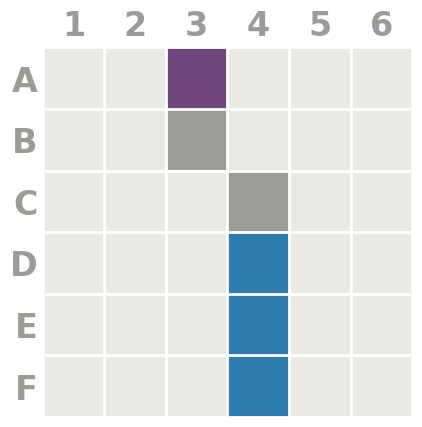

In [10]:
board = Board.from_trial_id(5)
board

In [11]:
# Create a model instance
model = QuestionGenerationModel(
    lm=lm,
    board=board,
    question_prompt=make_question_prompt(df),
    translation_prompt=make_question_to_code_prompt(df),
)

In [12]:
particles = await smc_standard(model, n_particles=3)


Partial question: Wh
|- EIG mean: 0.1217
|- Particle weight: 0.1217
  |- Completion: Which ship is at F3?
    |- Translation: (color F-3)
    |- Score: 0.3652
  |- Completion: Which ship is the longest?
    |- Translation: (max (map (lambda x0 (size x0)) (set AllColors)))
    |- Score: 0.0000
  |- Completion: Which ships are horizontal?
    |- Translation: (set (map (lambda x0 (if (== (orient x0) H) x0)) (set AllColors)))
    |- Score: 0.0000

Partial question: Can
|- EIG mean: 0.0000
|- Particle weight: 0.0000
  |- Completion: Can the ships be rotated?
    |- Translation: (any (map (lambda x0 (== (orient x0) R)) (set AllColors)))
    |- Score: 0.0000
  |- Completion: Can you make a board where every square is occupied by a ship?
    |- Translation: (all (map (lambda x0 (not (== (color x0) Water))) (set AllSquares)))
    |- Score: 0.0000
  |- Completion: Can ships move horizontally?
    |- Translation: (any (map (lambda x0 (== (orient x0) H)) (set AllColors)))
    |- Score: 0.0000

Par

In [14]:
particles

In [17]:
df_results = []
for i, p in enumerate(particles):
    df_p = pd.DataFrame(p.get_final_results())
    df_p["particle"] = i
    df_results.append(df_p)
df_results = pd.concat(df_results).reset_index(drop=True)
df_results

,prefix,completion,translation,score,type,particle
0,What is C8?,What is C8?,(color C-8),0.000000,final,0
1,What,What is the color of the ship at the far right?,(color (bottomright (coloredTiles (coloredTile...,0.000000,rollout,0
2,What,What is the ships ship?,(coloredTiles Ships),0.000000,rollout,0
3,What,What is the leftmost square occupied by the re...,(topleft (coloredTiles Red)),4.663079,rollout,0
4,What is,What is the coordinate of the last block of th...,(bottomright (coloredTiles Purple)),1.898524,rollout,0
...,...,...,...,...,...,...
76,Which divisions of height and width will requi...,Which divisions of height and width will requi...,(min (map (lambda x0 (size x0)) (set AllColors))),0.000000,rollout,2
77,Which divisions of height and width will requi...,Which divisions of height and width will requi...,(min (map (lambda x0 (size x0)) (set AllColors))),0.000000,rollout,2
78,Which divisions of height and width will requi...,Which divisions of height and width will requi...,(min (map (lambda x0 (size x0)) (set AllColors))),0.000000,rollout,2
79,Which divisions of height and width will requi...,Which divisions of height and width will requi...,(min (map (lambda x0 (size x0)) (set AllColors))),0.000000,rollout,2


In [18]:
df_results.sort_values("score", ascending=False).head(10)

,prefix,completion,translation,score,type,particle
3,What,What is the leftmost square occupied by the re...,(topleft (coloredTiles Red)),4.663079,rollout,0
60,Which divisions of height and width will,Which divisions of height and width will have ...,(++ (map (lambda x0 (size x0)) (set AllColors))),2.114224,rollout,2
56,Which divisions of height and,Which divisions of height and width are occupi...,(++ (map (lambda x0 (size x0)) (set AllColors))),2.114224,rollout,2
68,Which divisions of height and width will requi...,Which divisions of height and width will requi...,(++ (map (lambda x0 (size x0)) (set AllColors))),2.114224,rollout,2
55,Which divisions of height and,Which divisions of height and width are occupi...,(++ (map (lambda x0 (size x0)) (set AllColors))),2.114224,rollout,2
4,What is,What is the coordinate of the last block of th...,(bottomright (coloredTiles Purple)),1.898524,rollout,0
20,Can the,Can the purple ship touch the red ship?,(touch Purple Red),0.660055,rollout,1
9,What is C,What is C2?,(color C-2),0.574002,rollout,0
7,What is C,What is C1?,(color C-1),0.564621,rollout,0
39,Wh,Which ship is at F3?,(color F-3),0.365207,rollout,2


In [22]:
df_results.query("type == 'final'")

,prefix,completion,translation,score,type,particle
0,What is C8?,What is C8?,(color C-8),0.0,final,0
16,Can the white ship go right?,Can the white ship go right?,(canGoRight White),0.0,final,1
38,Which divisions of height and width will requi...,Which divisions of height and width will requi...,(min (map (lambda x0 (size x0)) (set AllColors))),0.0,final,2


In [ ]:
for p in particles:
    print(f"Question: {str(p.context)}")
    print(f"|- Program: {p.result['translation']}")
    print(f"|- EIG: {compute_score(board=board, program=p.result['translation'])}")
    print(f"|- Particle weight: {p.weight:.4f}")
    print()

Question: What are the positions of the ships on the board?
|- Program: (map (lambda x0 (coloredTiles x0)) (set AllColors))
|- EIG: 0
|- Particle weight: 0.0000

